<a href="https://colab.research.google.com/github/KJasman/ASL-Fingerspelling/blob/main/resnet/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import distutils.core, os, sys

# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions

!python -m pip install pyyaml --quiet

# IMPORTANT: uncomment and run ONE of the two lines below on session restart (either install or clone library)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!git clone 'https://github.com/facebookresearch/detectron2'

# install all required dependencies
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} --quiet

# bring detectron2 into local scope
sys.path.insert(0, os.path.abspath('./detectron2'))


Cloning into 'detectron2'...
remote: Enumerating objects: 15900, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 15900 (delta 69), reused 29 (delta 29), pack-reused 15781 (from 2)
Receiving objects: 100% (15900/15900), 6.44 MiB | 22.43 MiB/s, done.
Resolving deltas: 100% (11570/11570), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.6 MB/s eta 0:00:00


In [3]:
import cv2, json, random, time, os, io, contextlib, re

import detectron2, torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.config import get_cfg

from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets.coco import load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode, Instances
from detectron2.utils.visualizer import Visualizer, ColorMode

In [4]:
setup_logger()
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# versioning info and check that NVIDIA driver is good to go
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [6]:
# SETTINGS
TRAIN_JSON = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json"
TRAIN_IMGS = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train"
TRAIN_DATASET = "asl_train"

VALID_JSON = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid/_annotations.coco.json"
VALID_IMGS = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/valid"
VALID_DATASET = "asl_valid"

TEST_JSON = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/test/_annotations.coco.json"
TEST_IMGS = "/content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/test"
TEST_DATASET = "asl_test"

CLASSES = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

AUGMENT_DATA = False
L_RATE = 0.0025
ITERS = 500
IMG_BATCH_SIZE = 64
RESNET_MODEL = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml" # option 50 layers - "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
DECAY_MULT = 0
DECAY_POINTS = ()


In [7]:
def get_fixed_dataset(json_file, image_root):
# Fix dataset metadata (remove "Letter" class from thing_classes (discrepancy in JSON file))
    dataset_dicts = load_coco_json(json_file, image_root) # load target dataset

    # Shift category_id so that indexing goes 0-25 after "Letters" removed
    for d in dataset_dicts:
        for ann in d["annotations"]:
            ann["category_id"] -= 1

    return dataset_dicts

def register_fixed_asl(name, json_file, image_root):
#Register dataset and set metadata correctly (automatic includes "Letter" at index 0)
    DatasetCatalog.register(name, lambda: get_fixed_dataset(json_file, image_root))
    MetadataCatalog.get(name).thing_classes = CLASSES


# Register training and validation/testing sets (can swap VALID for TEST as needed)
if TRAIN_DATASET not in DatasetCatalog.list():
    register_fixed_asl(
        name=TRAIN_DATASET,
        json_file=TRAIN_JSON,
        image_root=TRAIN_IMGS
    )

if TEST_DATASET not in DatasetCatalog.list():
    register_fixed_asl(
        name=TEST_DATASET,
        json_file=TEST_JSON,
        image_root=TEST_IMGS
    )

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
[08/01 23:54:31 d2.data.datasets.coco]: Loading /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json takes 6.46 seconds.
[08/01 23:54:31 d2.data.datasets.coco]: Loaded 1512 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
[08/01 23:54:31 d2.data.datasets.coco]: Loaded 1512 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json


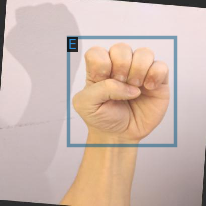

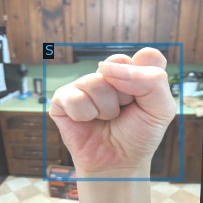

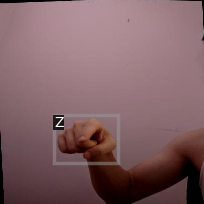

In [8]:
# DEBUGGING
# Check that "Letters" isn't in thing_classes
meta = MetadataCatalog.get(TRAIN_DATASET)
print(meta.thing_classes)

# Confirm that indexing starts at 0 and goes to 25 (i.e. manual shift worked above)
dataset = DatasetCatalog.get(TRAIN_DATASET)
print(set(ann["category_id"] for d in dataset for ann in d["annotations"]))

# take a peek at annotated training data
for datapt in random.sample(DatasetCatalog.get(TRAIN_DATASET), 3):
    img = cv2.imread(datapt["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=meta, scale=0.5)
    out = visualizer.draw_dataset_dict(datapt)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [9]:
cfg = get_cfg()

# load resnet config from Detectron2's set of models
cfg.merge_from_file(model_zoo.get_config_file(RESNET_MODEL))

# start with a pre-trained COCO object detection model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(RESNET_MODEL)

# name datasets
cfg.DATASETS.TRAIN = (TRAIN_DATASET,)
cfg.DATASETS.TEST = (TEST_DATASET,)

# number of classes: 26 (A-Z)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 26

# number of iterations
cfg.SOLVER.MAX_ITER = ITERS

cfg.SOLVER.BASE_LR = L_RATE   # learning rate

# initialize LR DECAY
cfg.SOLVER.GAMMA = DECAY_MULT
cfg.SOLVER.STEPS = DECAY_POINTS

cfg.SOLVER.IMS_PER_BATCH = 32
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = IMG_BATCH_SIZE

# set threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Seed makes results more reproducible
cfg.SEED = 42

# set output directory
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# document config for later reference
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

In [10]:
# create trainer instance, and train!!
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/01 23:54:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:00, 258MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[08/01 23:54:34 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/01 23:55:34 d2.utils.events]:  eta: 0:21:21  iter: 19  total_loss: 4.085  loss_cls: 3.154  loss_box_reg: 0.919  loss_rpn_cls: 0.01333  loss_rpn_loc: 0.007007    time: 2.7399  last_time: 2.4613  data_time: 1.8568  last_data_time: 1.5230   lr: 9.7405e-05  max_mem: 26636M
[08/01 23:56:31 d2.utils.events]:  eta: 0:20:31  iter: 39  total_loss: 2.192  loss_cls: 1.229  loss_box_reg: 0.9197  loss_rpn_cls: 0.01283  loss_rpn_loc: 0.007443    time: 2.7208  last_time: 2.8720  data_time: 1.7496  last_data_time: 1.9113   lr: 0.00019731  max_mem: 26636M
[08/01 23:57:05 d2.utils.events]:  eta: 0:19:22  iter: 59  total_loss: 1.939  loss_cls: 0.9627  loss_box_reg: 0.9667  loss_rpn_cls: 0.003657  loss_rpn_loc: 0.004744    time: 2.3766  last_time: 1.1000  data_time: 0.7769  last_data_time: 0.1509   lr: 0.0002972  max_mem: 26636M
[08/01 23:57:27 d2.utils.events]:  eta: 0:17:55  iter: 79  total_loss: 1.885  loss_cls: 0.9216  loss_box_reg: 0.9587  loss_rpn_cls: 0.002672  loss_rpn_loc: 0.004209    time: 2

In [11]:
# configure validation step

cfg_path = "/content/output/config.yaml"

cfg.merge_from_file(cfg_path)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set testing threshold (start low)

predictor = DefaultPredictor(cfg)

[08/02 00:04:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


In [12]:
# get fps
setup_logger()

def measure_inference_speed(predictor, image_dir, max_images=100):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    image_files = image_files[:max_images]

    total_time = 0
    times = []

    for fname in image_files:
        img_path = os.path.join(image_dir, fname)
        image = cv2.imread(img_path)

        start = time.time()
        outputs = predictor(image)
        end = time.time()

        elapsed = end - start
        times.append(elapsed)
        total_time += elapsed

    avg_time = total_time / len(times)
    fps = 1 / avg_time

    print(f"Tested {len(times)} images")
    print(f"Average inference time per image: {avg_time * 1000:.2f} ms")
    print(f"Approximate FPS: {fps:.2f}")
    return avg_time, fps

measure_inference_speed(predictor, TEST_IMGS)

Tested 72 images
Average inference time per image: 48.61 ms
Approximate FPS: 20.57


(0.04860700832472907, 20.57316495019186)

[08/02 00:05:22 d2.data.datasets.coco]: Loaded 72 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/test/_annotations.coco.json
[08/02 00:05:22 d2.data.datasets.coco]: Loaded 1512 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/train/_annotations.coco.json
Test validation data:


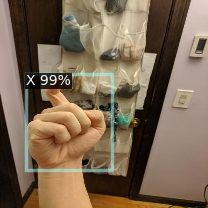

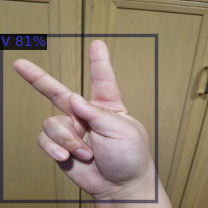

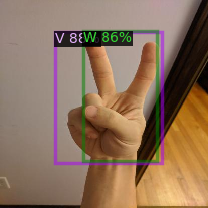

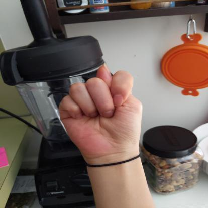

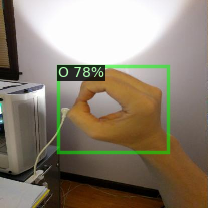

In [13]:
# Make predictions on new data
dataset_dicts_v = DatasetCatalog.get(TEST_DATASET)
metadata_v = MetadataCatalog.get(TEST_DATASET)

dataset_dicts_t = DatasetCatalog.get(TRAIN_DATASET)
metadata_t = MetadataCatalog.get(TRAIN_DATASET)

def test_random_images(dataset_dicts, metadata):
  for d in random.sample(dataset_dicts, 5):
      im = cv2.imread(d["file_name"])
      outputs = predictor(im)
      v = Visualizer(im[:, :, ::-1],
                    metadata=metadata,
                    scale=0.5,
      )
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(out.get_image()[:, :, ::-1])

print("Test validation data:")
test_random_images(dataset_dicts_v, metadata_v)

[08/02 00:05:22 d2.data.datasets.coco]: Loaded 72 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/test/_annotations.coco.json
[08/02 00:05:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/02 00:05:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/02 00:05:22 d2.data.common]: Serializing 72 elements to byte tensors and concatenating them all ...
[08/02 00:05:22 d2.data.common]: Serialized dataset takes 0.02 MiB
[08/02 00:05:22 d2.data.datasets.coco]: Loaded 72 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/test/_annotations.coco.json


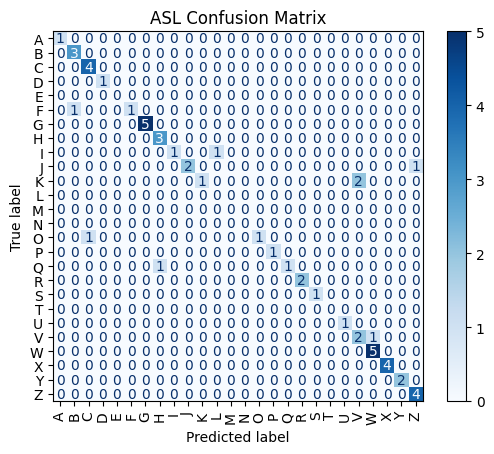

In [14]:
# Build Confusion Matrix
def collect_preds_and_labels(cfg, model, dataset_name):
    from detectron2.data import DatasetCatalog, build_detection_test_loader
    from detectron2.utils.logger import setup_logger
    import torch

    model.eval()
    loader = build_detection_test_loader(cfg, dataset_name)
    dataset_dicts = DatasetCatalog.get(dataset_name)

    gts = []
    preds = []

    for data, inputs in zip(dataset_dicts, loader):
        # Get ground truth class for each image
        gt_class = data["annotations"][0]["category_id"]
        gts.append(gt_class)

        with torch.no_grad():
            outputs = model(inputs)[0]["instances"]
            scores = outputs.scores.cpu().numpy() if outputs.has("scores") else []
            pred_classes = outputs.pred_classes.cpu().numpy() if outputs.has("pred_classes") else []

            if len(scores) > 0:
                # get highest-confidence prediction over testing threshold
                best_idx = scores.argmax()
                if scores[best_idx] > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
                    preds.append(pred_classes[best_idx])
                else:
                    preds.append(-1)  # i.e. no prediction over threshold
            else:
                preds.append(-1)

    return np.array(gts), np.array(preds)



def plot_confusion_matrix(gt, pred, class_names):
    cm = confusion_matrix(gt, pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=90, cmap="Blues")
    plt.title("ASL Confusion Matrix")
    plt.show()

gt, pred = collect_preds_and_labels(cfg, trainer.model, TEST_DATASET)
plot_confusion_matrix(gt, pred, MetadataCatalog.get(TEST_DATASET).thing_classes)

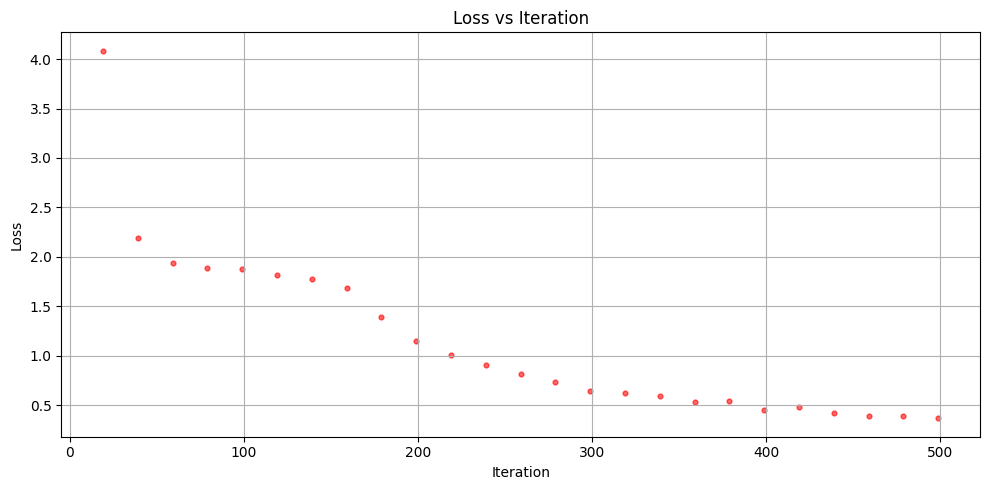

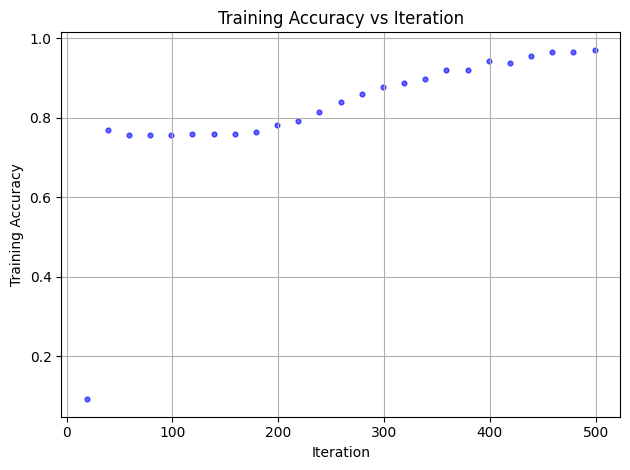

In [15]:
log_path = "output/metrics.json"  # Path to model metrics

iterations = []
total_losses = []
accuracies = []

with open(log_path, 'r') as f:
    for line in f:
        entry = json.loads(line)
        if "iteration" in entry:
            iterations.append(entry["iteration"])
            total_losses.append(entry.get("total_loss", float('nan')))
            accuracies.append(entry.get("fast_rcnn/cls_accuracy", float('nan')))

# plot learning curves
plt.figure(figsize=(10, 5))

# plot total loss
plt.scatter(iterations, total_losses, s=12, color='red', label="Total Loss", alpha=0.6)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.grid(True)

plt.tight_layout()
plt.show()

# plot classification accuracy
plt.scatter(iterations, accuracies, s=12, color='blue', label="Cls Accuracy", alpha=0.6)
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Iteration")
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
evaluator = COCOEvaluator(TEST_DATASET, cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, TEST_DATASET)
results = inference_on_dataset(trainer.model, val_loader, evaluator)
print("mAP:", results["bbox"]["AP"])

[08/02 00:05:26 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [08/02 00:05:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/02 00:05:26 d2.evaluation.coco_evaluation]: Trying to convert 'asl_test' to COCO format ...
[08/02 00:05:26 d2.data.datasets.coco]: Converting annotations of dataset 'asl_test' to COCO format ...)
[08/02 00:05:26 d2.data.datasets.coco]: Loaded 72 images in COCO format from /content/drive/MyDrive/ColabNotebooks/resnet/ASL-COCO-JSON/test/_annotations.coco.json
[08/02 00:05:26 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/02 00:05:26 d2.data.datasets.coco]: Conversion finished, #images: 72, #annotations: 72
[08/02 00:05:26 d2.data.datasets.coco]: Caching COCO format annotations at '/content/output/asl_test_coco_format.json' ...
[08/02 00:05:26 d2.data.datasets.coco]: Loaded 72 images